# Coordinate Descent for Lasso

I'm trying to see how good a bad coordinate descent algorithm is compared to the Cython optimised Lasso in SKLearn. If this is promising I will use this trick to do implement the most opaque part of Tibs pliable lasso.

In [1]:
import numpy as np
import numpy.linalg as la
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as graph
import seaborn as sns

from sklearn.linear_model import Lasso
from sklearn.datasets import load_boston

In [2]:
x, y = load_boston(True)
print(x.shape, y.shape)

(506, 13) (506,)


# Ground Truth

In [3]:
%%timeit
gt = Lasso(alpha=2, fit_intercept=False).fit(x, y)

1.25 ms ± 12.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [4]:
gt = Lasso(alpha=2, fit_intercept=False).fit(x, y)
print(gt.coef_)

[-2.42991573e-02  5.31785193e-02 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  3.05467635e+00  5.11427657e-02 -0.00000000e+00
  0.00000000e+00 -1.67773867e-03 -0.00000000e+00  2.07160117e-02
 -5.98679048e-01]


# Custom Coordinate Descent

506 13
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Ground Truth Cost 23.315123868478164
Initial Cost 296.0734584980237
J_1 = 94.26234922473651
J_2 = 57.7726619655116
J_3 = 48.41119589259517
J_4 = 42.95568294818235
J_5 = 38.9168862005453
J_6 = 35.85729804244692
J_7 = 33.61496253552244
J_8 = 31.77520110669446
J_9 = 30.23466944108655
J_10 = 28.959117209399835
J_11 = 27.893341691330264
J_12 = 27.010537680995554
J_13 = 26.398971254403968
J_14 = 25.980907825440035
J_15 = 25.628038769776367
J_16 = 25.335610545813005
J_17 = 25.08644816452142
J_18 = 24.873629344605245
J_19 = 24.690473544249592
J_20 = 24.542195925401565
J_21 = 24.46161058673571
J_22 = 24.39698111652681
J_23 = 24.34742409932715
J_24 = 24.310168619690295
J_25 = 24.27858310662916
J_26 = 24.25170100275342
J_27 = 24.227546201643726
J_28 = 24.20517700205864
J_29 = 24.18346778536835
J_30 = 24.16187395389199
J_31 = 24.140682430093335
J_32 = 24.11652074091671
J_33 = 24.0975789289459
J_34 = 24.078499270659826
J_35 = 24.059752084104815
J_36 =

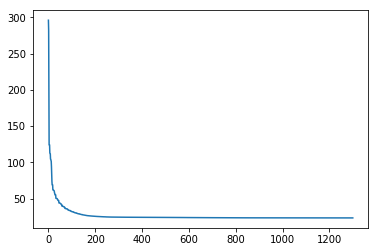

In [5]:
# Helper Functions
def model(x, m):
    return x @ m

def objective_function(x, y, m, lam):
    return 0.5 * ((y - model(x, m))**2).mean() + lam * la.norm(m, 1)

def partial_objective_function(mi, x, y, m, lam, pi):
    m[pi] = mi
    return objective_function(x, y, m , lam)

# Class
class CustomLasso:
    def __init__(self, lam):
        self.lam = lam
        self.coef_ = None
        self.history = []
        
    def fit(self, X, y):
        self.history = []
        
        n, p = X.shape
        print(n, p)
        
        m = np.zeros(p)
        print(m)
        
        # Coordinate Descent
        self.history.append(objective_function(x, y, m, self.lam))
        print(f'Ground Truth Cost {objective_function(x, y, gt.coef_, gt.alpha)}')
        print(f'Initial Cost {self.history[-1]}')
        
        for i in range(100):
            for pi in range(p):
                m[pi] = opt.fmin(partial_objective_function, m[pi], args=(x, y, m.copy(), self.lam, pi), disp=False)
                m[abs(m) < 1e-15] = 0  # Polish
                self.history.append(objective_function(x, y, m, self.lam))
            print(f'J_{i+1} = {self.history[-1]}')
        
        print(m)
        self.coef_ = m.copy()
        return self
    
    def predict(self, X):
        return model(X, self.coef_)
    

# Test function
lasso = CustomLasso(lam=2).fit(x, y)

graph.plot(lasso.history)
graph.show()

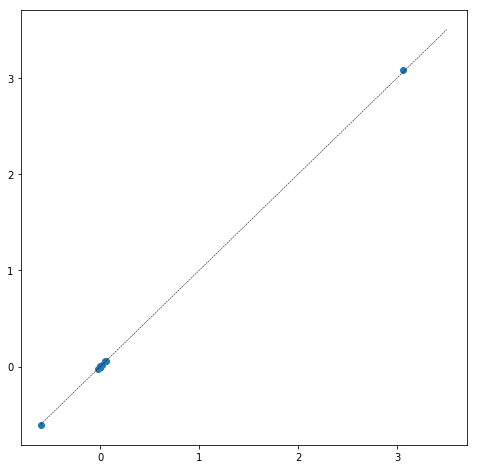

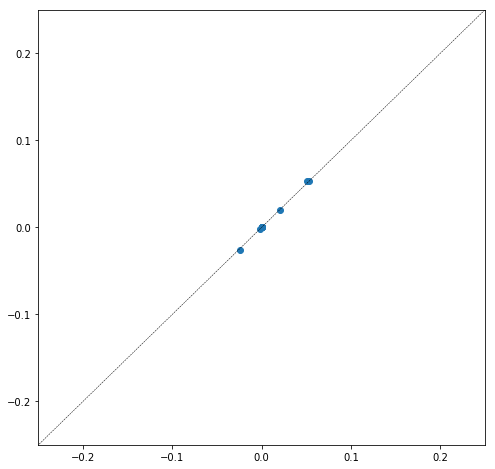

[-2.42991573e-02  5.31785193e-02 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  3.05467635e+00  5.11427657e-02 -0.00000000e+00
  0.00000000e+00 -1.67773867e-03 -0.00000000e+00  2.07160117e-02
 -5.98679048e-01]
[-2.65336120e-02  5.33883129e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  3.08207168e+00  5.35141490e-02  0.00000000e+00
  6.51399000e-04 -1.69731226e-03  0.00000000e+00  2.01544610e-02
 -6.07579156e-01]


In [6]:
# Coefficent Comparison
graph.figure(figsize=(8, 8))
graph.plot(gt.coef_, lasso.coef_, 'o')
graph.plot([-0.6, 3.5], [-0.6, 3.5], '--', color='black', linewidth=0.5)
graph.show()

graph.figure(figsize=(8, 8))
graph.plot(gt.coef_, lasso.coef_, 'o')
graph.plot([-0.6, 3.5], [-0.6, 3.5], '--', color='black', linewidth=0.5)
graph.xlim([-0.25, 0.25])
graph.ylim([-0.25, 0.25])
graph.show()

print(gt.coef_)
print(lasso.coef_)

In [7]:
class CustomLasso:
    def __init__(self, lam):
        self.lam = lam
        self.coef_ = None
        self.history = []
        
    def fit(self, X, y):
        self.history = []
    
        n, p = X.shape
        m = np.zeros(p)
        
        # Coordinate Descent
        self.history.append(objective_function(x, y, m, self.lam))
        for i in range(100):
            for pi in range(p):
                m[pi] = opt.fmin(partial_objective_function, m[pi], args=(x, y, m.copy(), self.lam, pi), disp=False)
                m[abs(m) < 1e-15] = 0  # Polish
                self.history.append(objective_function(x, y, m, self.lam))
        
        self.coef_ = m.copy()
        return self
    
    def predict(self, X):
        return model(X, self.coef_)

In [8]:
%%timeit
lasso = CustomLasso(lam=2).fit(x, y)

885 ms ± 8.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


My quick BS version is ~900x slower than sklearn's BUT the concept was proven. That is I can use scipy to force coordinate descent to work since I cannot figure out Tibs crazy fortran code. The extra problem is now I need to run iterations of the Pliable Lasso